# Continuous Measurement of a Qubit System
This purpose of this notebook is to simulate a qubit-resonator system while it is measured using a continuous measurement scheme. 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")


## Definition of Qubit and Resonator

In [2]:
## Setup parameters:
simulation_steps = 2001

# Setup Qubit, Resonator and Coupling
qubit_states    = 3
n_cutoff        = 15
EJ              = 15 * 2 * np.pi # h GHz
EC              = EJ / 25

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.025
driving_time           = (0, 1000)
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)


# Loss parameters:
# Setup the qubit decay
rate_qubit_decay  = 1 / 1000
rate_qubit_excite = 0.0

readout_photon_rate = 1 / 100
readout_efficiency  = 1


# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()


# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [3]:
# Derived quantities

# Calculate all types of constants, which is useful for further analysis:
omega_01 = H_qubit.diag()[1] - H_qubit.diag()[0]
omega_02 = H_qubit.diag()[2] - H_qubit.diag()[0]
omega_12 = H_qubit.diag()[2] - H_qubit.diag()[1]

# Calculate the dispersive shifts
# Multi qubit shifts
g_squared_matrix    = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix     = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r             = resonator_frequency

# The Chi-matrix
chi_matrix          = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts   = chi_matrix.sum(axis = 1) / 2 / np.pi


# Omega resonator for qubits
omega_resonator_qubit = resonator_frequency + dispersive_shifts

## Define Hamiltonian:

Non interacting:  

$H_{eff} = (\omega_r - \omega_d  + \sum_k \chi_k \ket{k}\bra{k} ) a^\dagger a$

Driving

$H_{d, eff} = \epsilon (a^\dagger + a)$

In [4]:
from qutip import tensor

# Drive inbetween the two qubit states
drive_frequency = (omega_resonator_qubit[0] + omega_resonator_qubit[1]) / 2 

# Define the Hamiltonian components. 
H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)
H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)
H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

H =  H_res + H_disp + H_drive

## Deterministic Simulation

In [5]:
from qutip import ket2dm, operator_to_vector, create

# Initial_states
ground_resonator_state = qutip.basis(resonator_states, 0)
ground_qubit_state     = qutip.basis(qubit_states, 0)
excited_qubit_state    = qutip.basis(qubit_states, 1)

# Define operators

## Collapse Operators
# Qubit decay
qubit_decay_operator    = np.sqrt(rate_qubit_decay) * destroy(qubit_states)
qubit_excite_operator   = np.sqrt(rate_qubit_excite) * create(qubit_states)

# Resonator decay
resonator_decay_operator = np.sqrt(readout_photon_rate) * destroy(resonator_states)

# Define the collapse operators
c_ops = [
    tensor(qubit_decay_operator,        qutip.qeye(resonator_states)),
    tensor(qubit_excite_operator,       qutip.qeye(resonator_states)),
    tensor(qutip.qeye(qubit_states),    resonator_decay_operator)
]

## Expectation Operators
# Qubit Occupation
qubit_occupation_operator = qutip.num(qubit_states)

# Resonator Occupation
resonator_occupation_operator = qutip.num(resonator_states)

resonator_I = a + a_dag
resonator_Q = 1j * (a - a_dag)

# Define the collapse operators
e_ops = [
    tensor(qubit_occupation_operator, qutip.qeye(resonator_states)),
    tensor(qutip.qeye(qubit_states), resonator_occupation_operator),
    tensor(qutip.qeye(qubit_states), resonator_I),
    tensor(qutip.qeye(qubit_states), resonator_Q)
]


In [6]:
# Simulation
from qutip import mesolve

# Define the time steps
tlist = np.linspace(driving_time[0], driving_time[1], simulation_steps)

# Run the simulation
result_ground = mesolve(
    H,
    tensor(ground_qubit_state, ground_resonator_state),
    tlist,
    c_ops = c_ops,
    e_ops = e_ops,
    progress_bar = True
)

result_excited = mesolve(
    H,
    tensor(excited_qubit_state, ground_resonator_state),
    tlist,
    c_ops = c_ops,
    e_ops = e_ops,
    progress_bar = True
)

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.24s. Est. time left: 00:00:00:00
50.0%. Run time:   0.30s. Est. time left: 00:00:00:00
60.0%. Run time:   0.37s. Est. time left: 00:00:00:00
70.0%. Run time:   0.43s. Est. time left: 00:00:00:00
80.0%. Run time:   0.49s. Est. time left: 00:00:00:00
90.0%. Run time:   0.55s. Est. time left: 00:00:00:00
Total run time:   0.62s
10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.29s. Est. time left: 00:00:00:00
60.0%. Run time:   0.35s. Est. time left: 00:00:00:00
70.0%. Run time:   0.41s. Est. time left: 00:00:00:00
80.0%. Run time:   0.48s. Est. time left: 00:00:00:00
90.0%. Run time:   0.53s. Est. time left: 00:00:00:00
Tota

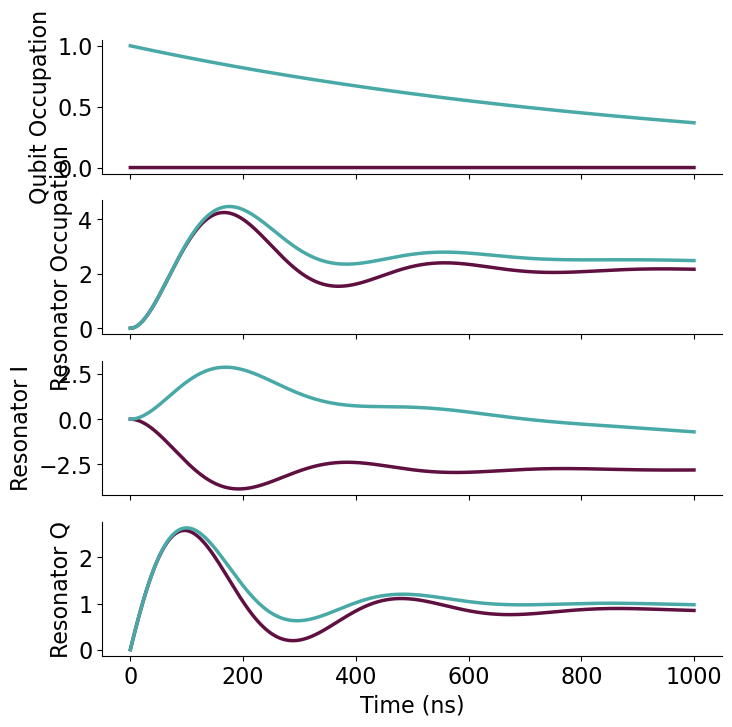

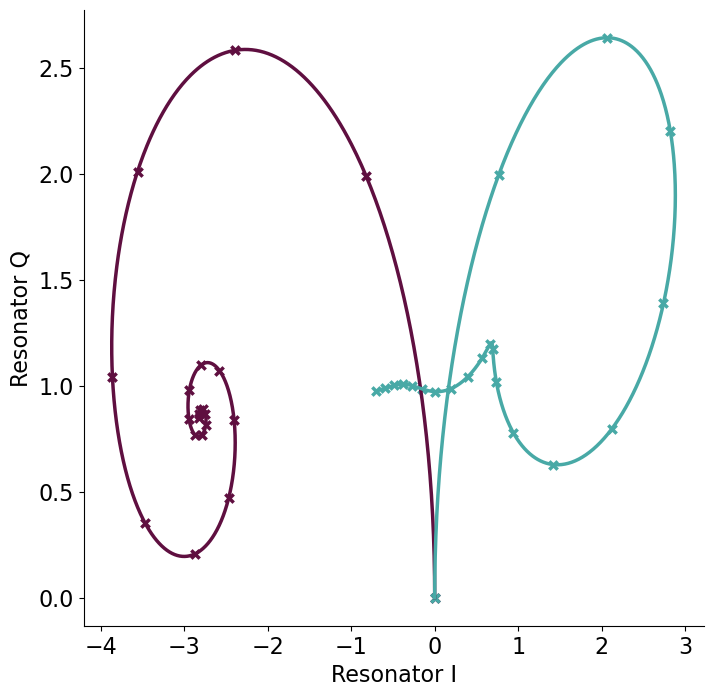

In [7]:
# Plotting the expectation values in 2 times 2 grid
def plot_expectation_values(result_ground, result_excited, tlist):

    fig, ax = plt.subplots(nrows = 4, figsize = (8, 8), sharex = True)

    ax[0].plot(tlist, result_ground.expect[0], label = "Ground")
    ax[0].plot(tlist, result_excited.expect[0], label = "Excited")
    ax[0].set_ylabel("Qubit Occupation")

    ax[1].plot(tlist, result_ground.expect[1])
    ax[1].plot(tlist, result_excited.expect[1])
    ax[1].set_ylabel("Resonator Occupation")

    ax[2].plot(tlist, result_ground.expect[2])
    ax[2].plot(tlist, result_excited.expect[2])
    ax[2].set_ylabel("Resonator I")

    ax[3].plot(tlist, result_ground.expect[3])
    ax[3].plot(tlist, result_excited.expect[3])
    ax[3].set_ylabel("Resonator Q")

    ax[3].set_xlabel("Time (ns)")

    return fig, ax

def plot_IQ_trajectory(ground_IQ, excited_IQ, plot_every = None, alpha_line = 1):
        fig, ax = plt.subplots(nrows = 1, figsize = (8, 8), sharex = True)
    
        ax.plot(ground_IQ[0],  ground_IQ[1],  label = "Ground", alpha = alpha_line)
        ax.plot(excited_IQ[0], excited_IQ[1], label = "Excited", alpha = alpha_line)
        ax.set_xlabel("Resonator I")
        ax.set_ylabel("Resonator Q")

        if plot_every:
            ax.scatter(ground_IQ[0][::plot_every],  ground_IQ[1][::plot_every],  marker = "x", color = "C0")
            ax.scatter(excited_IQ[0][::plot_every], excited_IQ[1][::plot_every], marker = "x", color = "C1")
    
        return fig, ax

fig_deterministic_exp, ax_deterministic_exp = plot_expectation_values(result_ground, result_excited, tlist)
fig_deterministic_IQ,  ax_deterministic_IQ  = plot_IQ_trajectory(result_ground.expect[2:], result_excited.expect[2:], plot_every = 100)


## Stochastic Simulation

In [8]:
from qutip import vector_to_operator, lindblad_dissipator, spre, spost, liouvillian, qeye
from qutip.expect import expect_rho_vec



qubit_decay =         tensor(qubit_decay_operator,        qutip.qeye(resonator_states)),
qubit_excitation =    tensor(qubit_excite_operator,       qutip.qeye(resonator_states)),
photon_decay =        tensor(qutip.qeye(qubit_states),    resonator_decay_operator)


# Define the deterministic part of the Hamiltonian
L = liouvillian(H)
D1 = lindblad_dissipator(tensor(qubit_decay_operator,        qutip.qeye(resonator_states)))
D2 = lindblad_dissipator(tensor(qubit_excite_operator,       qutip.qeye(resonator_states)))
D_from_measurement = lindblad_dissipator(tensor(qutip.qeye(qubit_states),    resonator_decay_operator))

evolution_operator = L + D1 + D2 + D_from_measurement

def evolution(time, rho_vec):
    return (L + D1 + D2 + D_from_measurement) * rho_vec


# Define the Stochastic Part giving rise to the noise/measurements

measure_quadrature_1 = np.sqrt(readout_photon_rate) * tensor(qeye(qubit_states), a)
measure_quadrature_2 = np.sqrt(readout_photon_rate) * 1j * tensor(qeye(qubit_states), a)

super_operator_1 = spre(measure_quadrature_1) * spost(measure_quadrature_1.dag())
super_operator_2 = spre(measure_quadrature_2) * spost(measure_quadrature_2.dag())

def measurement_evolution(time, rho_vec):
    expect1 = expect_rho_vec(super_operator_1.data, rho_vec, False)
    expect2 = expect_rho_vec(super_operator_2.data, rho_vec, False)
    drho1   = super_operator_1 * rho_vec - expect1 * rho_vec
    drho2   = super_operator_2 * rho_vec - expect2 * rho_vec
    return np.vstack([drho1, drho2])


# Expectations and measurements
e_vals_stochastic = [spre(operator) for operator in e_ops]
m_vals_stochastic = [spre(operator + operator.dag()) for operator in [measure_quadrature_1, measure_quadrature_2]]
dW_factors        = [np.sqrt(2 / readout_photon_rate), np.sqrt(2 / readout_photon_rate)]

In [9]:
from qutip import general_stochastic, parallel_map

result_ground_stochastic = general_stochastic(
    operator_to_vector(ket2dm(tensor(ground_qubit_state, ground_resonator_state))),
    tlist,
    evolution,
    measurement_evolution,
    ntraj = 10,
    e_ops = e_vals_stochastic,
    m_ops = m_vals_stochastic,
    dW_factors = dW_factors,
    len_d2 = 2, 
    progress_bar = True,
    solver = "platen",
    store_measurement = True,
    map_func = parallel_map    
)

result_excited_stochastic = general_stochastic(
    operator_to_vector(ket2dm(tensor(excited_qubit_state, ground_resonator_state))),
    tlist,
    evolution,
    measurement_evolution,
    ntraj = 10,
    e_ops = e_vals_stochastic,
    m_ops = m_vals_stochastic,
    dW_factors = dW_factors,
    len_d2 = 2,
    progress_bar = True,
    solver = "platen",
    store_measurement = True,
    map_func = parallel_map
)


10.0%. Run time:  33.65s. Est. time left: 00:00:05:02
20.0%. Run time:  33.88s. Est. time left: 00:00:02:15
30.0%. Run time:  37.85s. Est. time left: 00:00:01:28
40.0%. Run time:  39.02s. Est. time left: 00:00:00:58
50.0%. Run time:  41.10s. Est. time left: 00:00:00:41
60.0%. Run time:  41.58s. Est. time left: 00:00:00:27
70.0%. Run time:  42.61s. Est. time left: 00:00:00:18
80.0%. Run time:  43.31s. Est. time left: 00:00:00:10
90.0%. Run time:  44.19s. Est. time left: 00:00:00:04
100.0%. Run time:  45.08s. Est. time left: 00:00:00:00
Total run time:  45.10s
10.0%. Run time:  49.37s. Est. time left: 00:00:07:24
20.0%. Run time:  49.55s. Est. time left: 00:00:03:18
30.0%. Run time:  51.27s. Est. time left: 00:00:01:59
40.0%. Run time:  51.92s. Est. time left: 00:00:01:17
50.0%. Run time:  55.35s. Est. time left: 00:00:00:55
60.0%. Run time:  55.53s. Est. time left: 00:00:00:37
70.0%. Run time:  56.95s. Est. time left: 00:00:00:24
80.0%. Run time:  58.19s. Est. time left: 00:00:00:14
90.

(<Figure size 800x800 with 4 Axes>,
 array([<AxesSubplot:ylabel='Qubit Occupation'>,
        <AxesSubplot:ylabel='Resonator Occupation'>,
        <AxesSubplot:ylabel='Resonator I'>,
        <AxesSubplot:xlabel='Time (ns)', ylabel='Resonator Q'>],
       dtype=object))

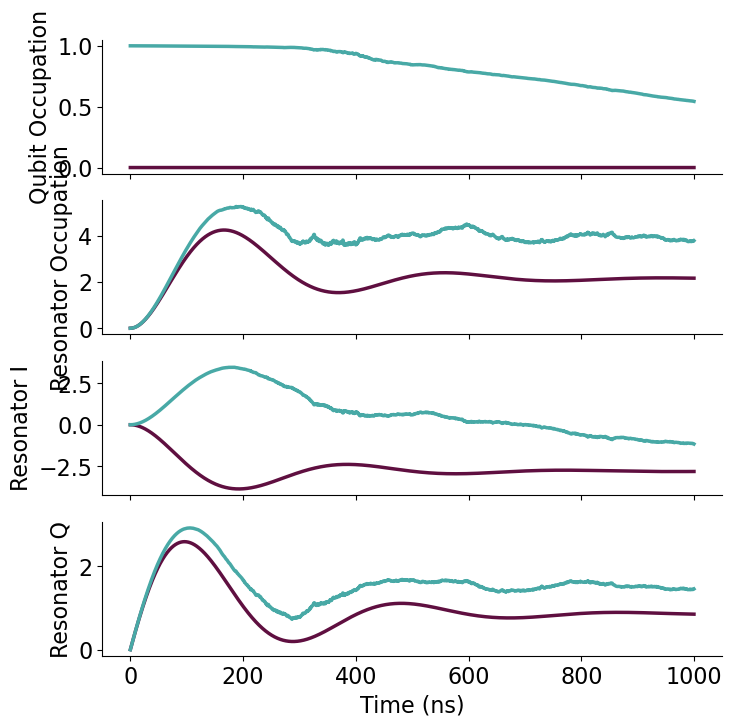

In [10]:
plot_expectation_values(result_ground_stochastic, result_excited_stochastic, tlist)


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Resonator I', ylabel='Resonator Q'>)

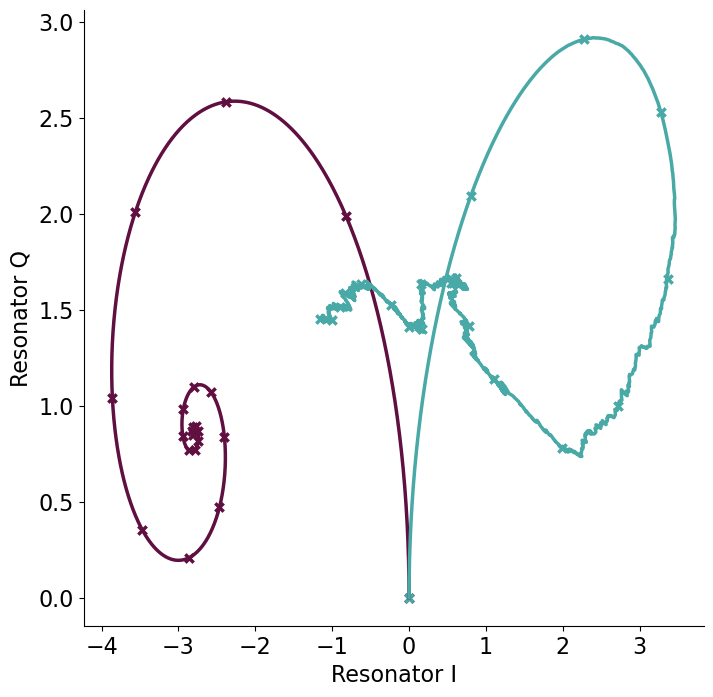

In [11]:
plot_IQ_trajectory(result_ground_stochastic.expect[2:], result_excited_stochastic.expect[2:], plot_every = 100)

/tmp/ipykernel_23377/1661964397.py:2: RuntimeWarning: divide by zero encountered in true_divide
  avg_measurements_ground = np.cumsum(measurements_ground, axis = 0).T / tlist
/tmp/ipykernel_23377/1661964397.py:2: RuntimeWarning: invalid value encountered in true_divide
  avg_measurements_ground = np.cumsum(measurements_ground, axis = 0).T / tlist
/tmp/ipykernel_23377/1661964397.py:5: RuntimeWarning: divide by zero encountered in true_divide
  avg_measurements_excited = np.cumsum(measurements_excited, axis = 0).T / tlist
/tmp/ipykernel_23377/1661964397.py:5: RuntimeWarning: invalid value encountered in true_divide
  avg_measurements_excited = np.cumsum(measurements_excited, axis = 0).T / tlist


[(-4.0, 4.0), (-4.0, 4.0)]

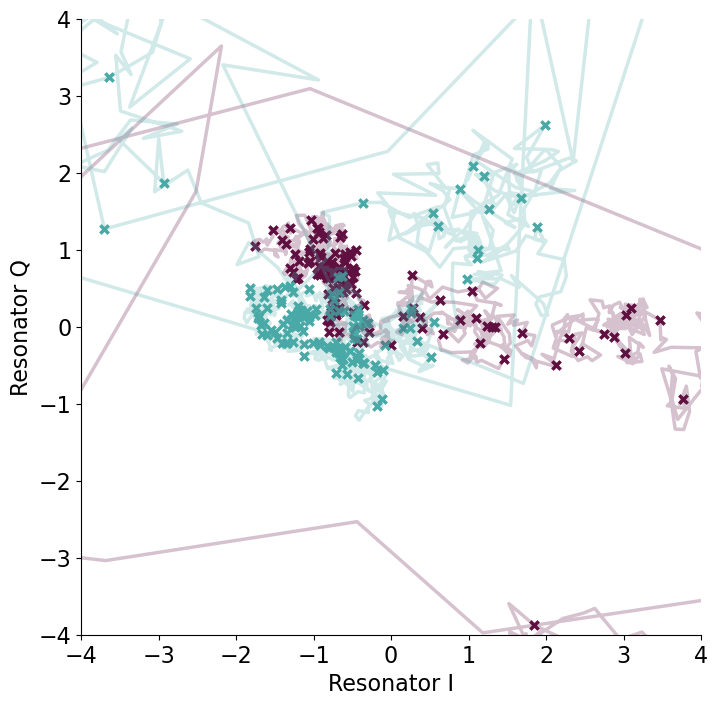

In [12]:
measurements_ground = np.array(result_ground_stochastic.measurement)[0]#.mean(axis = 0)
avg_measurements_ground = np.cumsum(measurements_ground, axis = 0).T / tlist

measurements_excited = np.array(result_excited_stochastic.measurement)[0]#.mean(axis = 0)
avg_measurements_excited = np.cumsum(measurements_excited, axis = 0).T / tlist

fig, ax = plot_IQ_trajectory(avg_measurements_ground.real, avg_measurements_excited.real, plot_every = 15, alpha_line = 0.25)

ax.set(
    xlim = (-4, 4),
    ylim = (-4, 4)
)
